In [9]:
import sys
import os
from pathlib import Path

root = Path().resolve()

if "analisis" in os.getcwd():
    root = root.parent
    os.chdir(root)

src_path = str(root.joinpath(Path("src")))

sys.path.append(src_path)
from utils import utils
from analytics.grouper import Grouper
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx
import numpy as np
import matplotlib as mpl

mpl.use("module://matplotlib-backend-sixel")

alerts = utils.get_data()
alerts.filter_by_group_time(120, True)
data = alerts.data
data.shape[0]

/Users/richard/proj


/Users/richard/.pyenv/versions/3.12.4/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
alerts = data[data["type"] == "ACCIDENT"]

In [11]:
g = Grouper(alerts, (10, 20))

Error al leer el archivo


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
alerts_grouped = alerts.copy()
alerts_grouped["group"] = alerts_grouped.to_crs(epsg=3857).geometry.apply(
    lambda x: g.calc_quadrant(
        *g.get_quadrant(
            (
                x.x,
                x.y,
            ),
        ),
    ),
)

In [5]:
alerts_grouped["group"].value_counts()

NameError: name 'alerts_grouped' is not defined

In [ ]:

alerts_grouped.to_crs(epsg=3857, inplace=True)

In [71]:
# Accidentes por grupo al día
grouped_day = (
    pd.DataFrame(
        {
            "group": alerts_grouped.group.value_counts().keys(),
            "qty/day": alerts_grouped.group.value_counts().values
            / (alerts_grouped["pub_millis"].max() - alerts_grouped["pub_millis"].min()).days,
        }
    )
).sort_values(ascending=False, by="qty/day")
grouped_day

,group,qty/day
0,96,1.380282
1,105,1.197183
2,114,0.957746
3,40,0.676056
4,50,0.619718
...,...,...
64,124,0.014085
65,44,0.014085
66,165,0.014085
67,159,0.014085


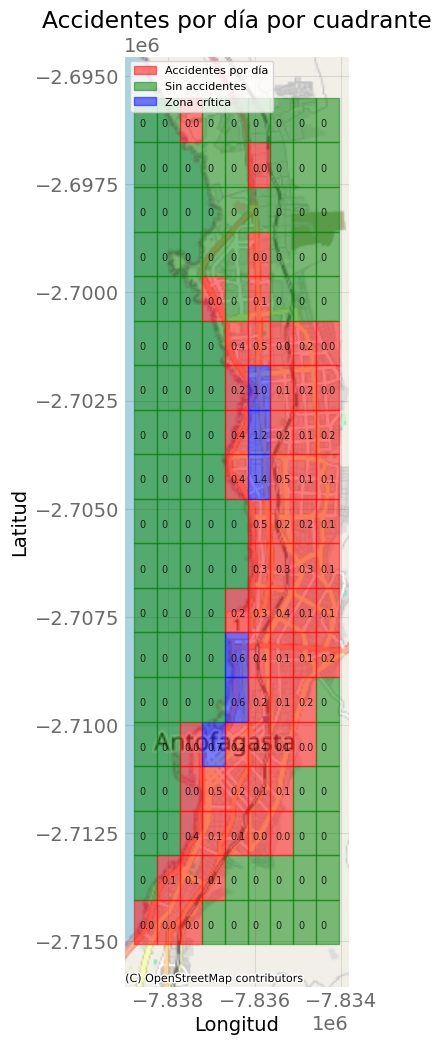

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 11.5))
xc, yc = g.get_center_points()
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
labels = [False, False, False]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = g.calc_quadrant(i, j)
        xf = xp - between_x / 2
        yf = yp - between_y / 2
        group_freq = (
            np.float16(grouped_day[grouped_day["group"] == quad]["qty/day"])[0]
            if quad in grouped_day["group"].values
            else 0
        )
        color = "r" if group_freq > 0 else "g"
        color = "b" if group_freq > 0.7 else color
        label = ""
        if group_freq == 0 and not labels[0]:
            label = "Sin accidentes"
            labels[0] = True

        if group_freq > 0 and not labels[1] and not label:
            label = "Accidentes por día"
            labels[1] = True

        if group_freq > 0.5 and not labels[2] and not label:
            label = "Zona crítica"
            labels[2] = True

        ax.text(
            xp - 150,
            yp - 150,
            round(group_freq, 1),
            fontsize=7,
            alpha=0.8,
            fontweight="bold",
        )
        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=0.5,
            color=color,
            label=label,
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por\ndía por segmento")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.legend(fontsize=8, loc="upper left")
plt.tight_layout()
plt.savefig("thesis/images/quad_mean_day_color.png")
plt.show()

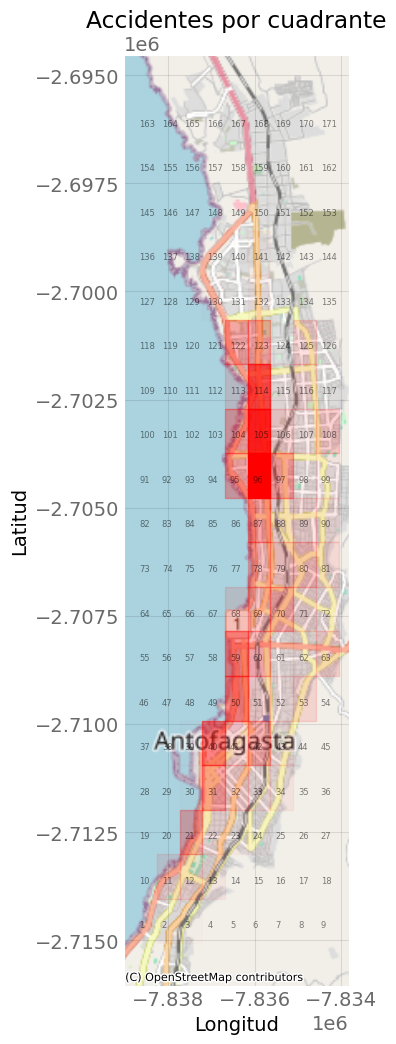

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 11.5))

xc, yc = g.get_center_points()
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = g.calc_quadrant(i, j)
        ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5, fontweight="bold")
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (alerts_grouped["group"].value_counts().max() - alerts_grouped["group"].value_counts().min())
            ),
            color="r",
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por segmento")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.tight_layout()
plt.savefig("thesis/images/quad_acc.png")
plt.show()

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 11.5))

xc, yc = g.get_center_points()
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
labels = [False, False, False]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = g.calc_quadrant(i, j)

        qty = (
            np.int16(
                alerts_grouped.value_counts("group").reset_index()[
                    alerts_grouped.value_counts("group").reset_index()["group"] == quad
                ]["count"]
            )[0]
            if quad in alerts_grouped.value_counts("group").reset_index()["group"].values
            else 0
        )

        color = "r" if qty > 0 else "g"
        color = "b" if qty > 140 else color
        label = ""
        if qty == 0 and not labels[0]:
            label = "Sin accidentes"
            labels[0] = True

        if qty > 0 and not labels[1] and label == "":
            label = "Accidentes totales en el periodo"
            labels[1] = True

        if qty > 90 and not labels[2] and label == "":
            label = "Zona crítica"
            labels[2] = True

        ax.text(
            xp - 150,
            yp - 150,
            qty,
            fontsize=6,
            fontweight="bold",
            alpha=0.5,
        )
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=0.5,
            color=color,
            label=label,
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por segmento")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.legend(fontsize=8, loc="upper left")
plt.tight_layout()
plt.savefig("thesis/images/quad_acc_color.png")
plt.show()

/var/folders/yx/rq7byh7s6351q7njcpzgf8_w0000gn/T/ipykernel_60779/3153385388.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(alerts_grouped.value_counts("group").reset_index()[alerts_grouped.value_counts("group").reset_index()["group"] == 132]["count"])


4

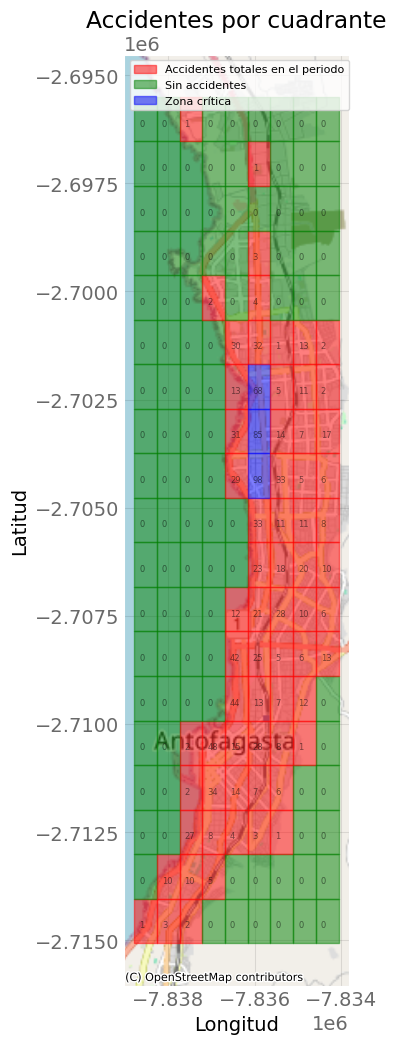

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 11.5))

xc, yc = g.get_center_points()
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = g.calc_quadrant(i, j)
        # ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5)
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (alerts_grouped["group"].value_counts().max() - alerts_grouped["group"].value_counts().min())
            ),
            color="r",
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por segmento")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.tight_layout()
plt.savefig("thesis/images/quad_acc_blank.png")
plt.show()

In [ ]:

np.array(g.get_center_points()[1]).T

In [ ]:

from math import ceil


def get_critical_segment_top_value(top: int, g: Grouper) -> tuple[float, int]:
    top = max(1, top)
    segment = alerts_grouped["group"].value_counts().sort_values(ascending=False).index[top - 1]
    max_value = alerts_grouped["group"].value_counts().sort_values(ascending=False).iloc[top - 1]

    print(segment)
    return max_value, g.calc_quadrant(ceil(segment / g.y_len), segment % g.y_len)



def get_critical_segment_coords(top: int, g: Grouper) -> tuple[float, float, float]:
    top_value, segment = get_critical_segment_top_value(top, g)
    if segment == 0 or g.x_grid is None or g.y_grid is None:
        msg = "Segment not found"
        raise ValueError(msg)

    x = ceil(segment / g.y_len) - 1
    y = segment % g.y_len - 1

    xc, yc = g.get_center_points()
    yc = np.array(yc).T

    xv = xc[0]
    yv = yc[0]

    return top_value, float(xv[x]), float(yv[y])


point = get_critical_segment_coords(1, g)
point

In [ ]:


def get_perimeter(x, y, r) -> tuple[tuple[float, float], tuple[float, float]]:
    return (x - r, x + r), (y - r, y + r)


point = get_critical_segment_coords(1, g)
x, y = get_perimeter(point[1], point[2], 0.1)
x, y

In [ ]:

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx


g = Grouper(alerts, (100, 150))

alerts_grouped = alerts.copy()
alerts_grouped["group"] = alerts_grouped.to_crs(epsg=3857).geometry.apply(
    lambda x: g.calc_quadrant(
        *g.get_quadrant(
            (
                x.x,
                x.y,
            ),
        ),
    ),
)

In [ ]:

def plot_critical_segment(top: int, g: Grouper, radius_m: float = 50.0):
    _, x_center, y_center = get_critical_segment_coords(top, g)

    crs_data = alerts_grouped.crs
    if crs_data is None:
        raise ValueError("alerts_grouped.crs is not defined")

    point_gdf = gpd.GeoDataFrame(geometry=[Point(x_center, y_center)], crs=crs_data)
    point_3857 = point_gdf.to_crs(epsg=3857)
    area_3857 = point_3857.buffer(radius_m)
    area = area_3857.to_crs(crs_data)

    fig, ax = plt.subplots(figsize=(10, 10))

    if hasattr(alerts_grouped, "geometry"):
        alerts_grouped.to_crs(epsg=3857).plot(ax=ax, alpha=0.2, color="gray")


    area.plot(ax=ax, alpha=0.6, edgecolor="red", linewidth=2, facecolor="none")

    xmin, ymin, xmax, ymax = area.total_bounds
    pad = radius_m * 4
    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(ymin - pad, ymax + pad)

    cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"Segmento crítico (top {top - 1})")
    ax.set_ylabel("Latitud (proj)")
    ax.set_xlabel("Longitud (proj)")
    fig.tight_layout()
    fig.savefig(f"thesis/images/critical_{top - 1}.png")
    fig.show()


plot_critical_segment(5, g, 150)

